# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [27]:
data_dir = '/data'
! pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

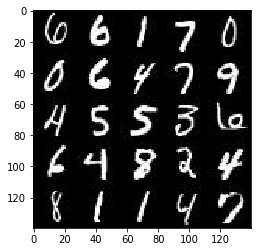

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

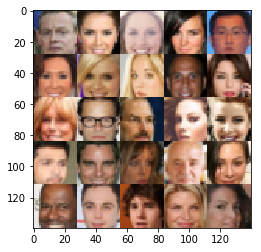

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],'real_input_images')
    input_z = tf.placeholder(tf.float32,[None, z_dim],'input_z')
    learning_rate = tf.placeholder(tf.float32,[],'learning_rate')
    return real_input_images,input_z,learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator',reuse=reuse):
        # layer 1 = lc_1, input = 28x28x3, kernel = 5x5
        lc_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        # leaky relu layer
        relu_1 = tf.maximum(alpha*lc_1,lc_1)
        # layer 2 = lc_2, input = 14x14x64, 
        lc_2 = tf.layers.conv2d(relu_1,128,5,strides=2,padding='same')
        lbn_2 = tf.layers.batch_normalization(lc_2,training=True)
        relu_2 = tf.maximum(alpha*lbn_2,lbn_2)
        # layer 3 = lc_3, input = 7x7x128, 
        lc_3 = tf.layers.conv2d(relu_2,256,5,strides=2,padding='same')
        lbn_3 = tf.layers.batch_normalization(lc_3,training=True)
        relu_3 = tf.maximum(alpha*lbn_3,lbn_3)
     
        # layer 4 = lr_flat, input = 4x4x256,
        lr_flat = tf.reshape(relu_3,(-1,4*4*256))
        logits_d = tf.layers.dense(lr_flat,1)
        output_d = tf.sigmoid(logits_d )
        
    return output_d,logits_d  

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    # build generator
    with tf.variable_scope('generator', reuse=(not is_train)):
        # hidden layer 1 ~ hd_1,
        hd_1 = tf.layers.dense(z,2*2*512)
        hr_1 = tf.reshape(hd_1,(-1,2,2,512))
        relu_1 = tf.maximum(alpha*hr_1,hr_1)
        
        # hidden layer 2 ~ hd_2, 
        hd_2 = tf.layers.conv2d_transpose(relu_1,256,5,strides=2,padding='valid')
        hbn_2 = tf.layers.batch_normalization(hd_2,training=is_train)
        relu_2 = tf.maximum(alpha*hbn_2,hbn_2)
        
        
        # hidden layer 3 ~ hc_3, 
        hc_3 = tf.layers.conv2d_transpose(relu_2,28,5,strides=2,padding='same')
        hbn_3 = tf.layers.batch_normalization(hc_3,training=is_train)
        relu_3 = tf.maximum(alpha*hbn_3,hbn_3)
        
      
        # logits, output,
        logits_g = tf.layers.conv2d_transpose(relu_3,out_channel_dim,5,strides=2,padding='same')
        out_g = tf.tanh(logits_g)
        
        # out_g
    return out_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    
    # d newtwork similar to example in Intro_to_GANs_exercise
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits\
                                             (logits=d_logits_real,labels=tf.ones_like\
                                              (d_model_real)*(1-0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits\
                                             (logits=d_logits_fake,labels=tf.zeros_like\
                                              (d_model_fake)))
    
    # calculate losses
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits\
                                    (logits=d_logits_fake,labels=tf.ones_like\
                                     (d_model_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # get the trainable_variables, split into generator and discriminator
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimization step
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_tr_op = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_tr_op = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
                                                                                                                
    return d_tr_op,g_tr_op

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model   
    steps = 0
    show_every = 100    
    print_every = 100 
    #
    #
    n_samples, width, height, channels = data_shape
    input_real, input_z, input_lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    #     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1             
                
                # sample with random uniform adding noise for the generator
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # optimize
                sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z,input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,input_lr:learning_rate})
                
                if steps % print_every == 0:
                    # after every epoch print losses
                    train_loss_d = d_loss.eval({input_real:batch_images,input_z:batch_z})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print('Epoch {}/{}...'.format(epoch_i,epoch_count),
                         'discriminator Loss: {:.4f}'.format(train_loss_d),
                         'Generator Loss {:.4f}'.format(train_loss_g))
                    # save losses but don't repeat this step
                    # losses.append((train_loss_d,train_loss_g))
                    
                if steps % show_every == 0:
                    # shows generator output
                    n_images = 25
                    # showing output
                    show_generator_output(sess,n_images,input_z,channels,data_image_mode)
                    
                                 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... discriminator Loss: 0.5479 Generator Loss 2.1351


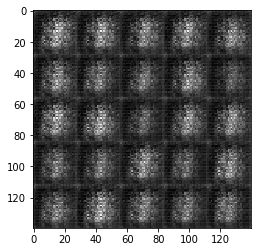

Epoch 0/2... discriminator Loss: 0.4440 Generator Loss 2.9026


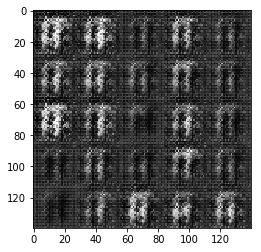

Epoch 0/2... discriminator Loss: 0.7895 Generator Loss 1.3311


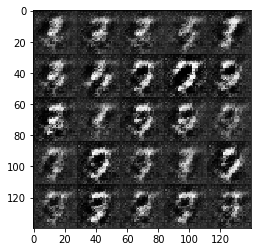

Epoch 0/2... discriminator Loss: 0.5787 Generator Loss 1.9392


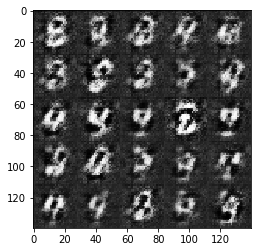

Epoch 0/2... discriminator Loss: 1.2329 Generator Loss 0.6492


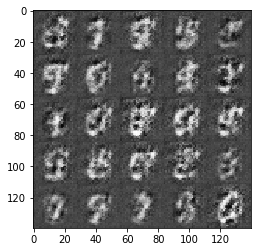

Epoch 0/2... discriminator Loss: 0.4180 Generator Loss 3.0760


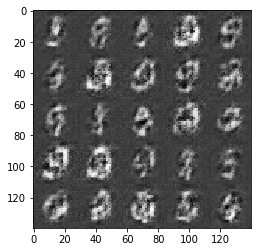

Epoch 0/2... discriminator Loss: 0.4043 Generator Loss 3.0010


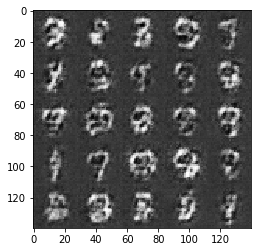

Epoch 0/2... discriminator Loss: 0.4469 Generator Loss 2.5282


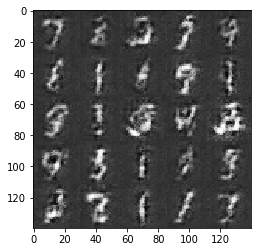

Epoch 0/2... discriminator Loss: 5.1472 Generator Loss 5.9850


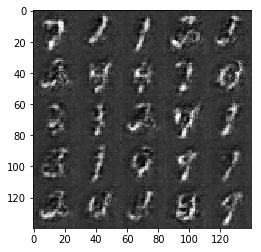

Epoch 1/2... discriminator Loss: 0.4338 Generator Loss 2.4849


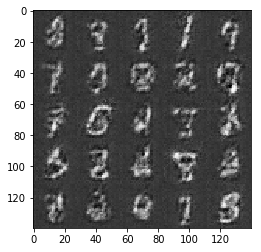

Epoch 1/2... discriminator Loss: 0.4733 Generator Loss 2.2162


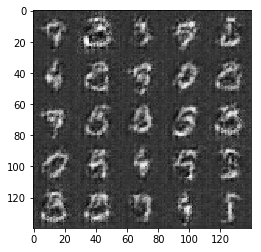

Epoch 1/2... discriminator Loss: 0.3808 Generator Loss 4.7256


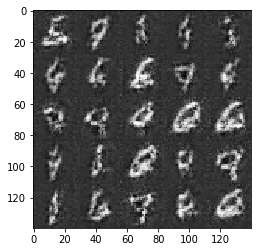

Epoch 1/2... discriminator Loss: 0.3914 Generator Loss 3.1647


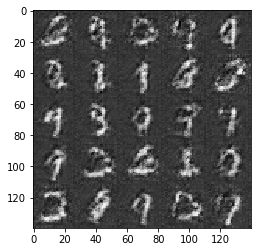

Epoch 1/2... discriminator Loss: 0.3764 Generator Loss 3.3789


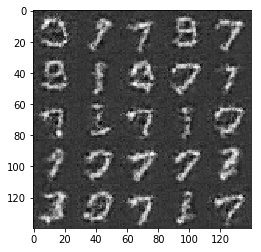

Epoch 1/2... discriminator Loss: 0.3762 Generator Loss 3.3643


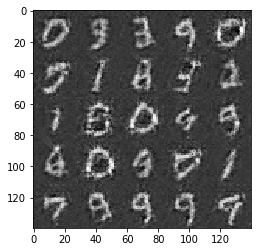

Epoch 1/2... discriminator Loss: 0.4987 Generator Loss 2.8063


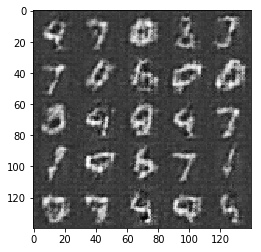

Epoch 1/2... discriminator Loss: 0.3585 Generator Loss 4.3280


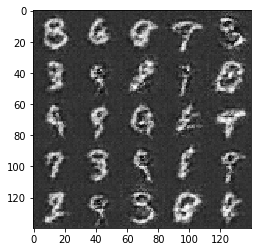

Epoch 1/2... discriminator Loss: 0.4555 Generator Loss 2.4018


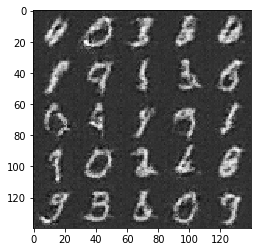

In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... discriminator Loss: 0.6107 Generator Loss 2.6416


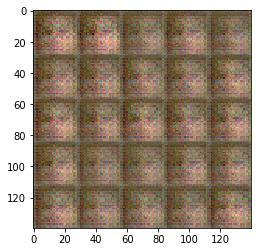

Epoch 0/1... discriminator Loss: 0.6139 Generator Loss 1.6360


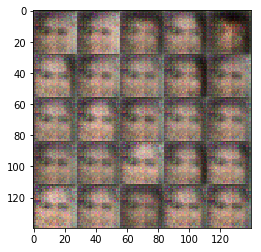

Epoch 0/1... discriminator Loss: 0.9453 Generator Loss 1.2148


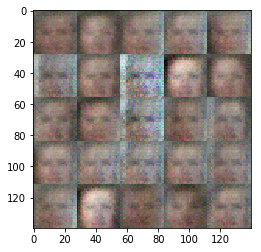

Epoch 0/1... discriminator Loss: 0.8633 Generator Loss 1.5095


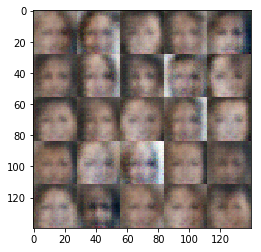

Epoch 0/1... discriminator Loss: 0.8552 Generator Loss 1.3294


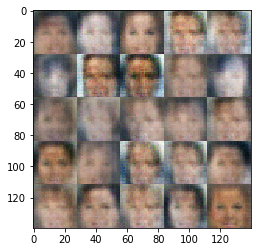

Epoch 0/1... discriminator Loss: 0.8923 Generator Loss 1.2875


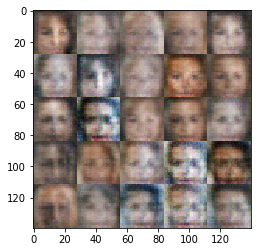

Epoch 0/1... discriminator Loss: 0.8741 Generator Loss 1.0658


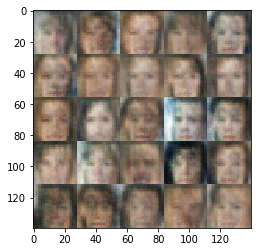

Epoch 0/1... discriminator Loss: 0.7937 Generator Loss 2.0394


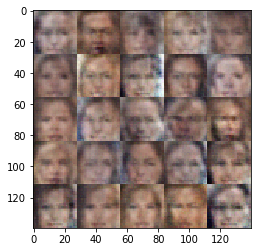

Epoch 0/1... discriminator Loss: 1.1473 Generator Loss 0.6873


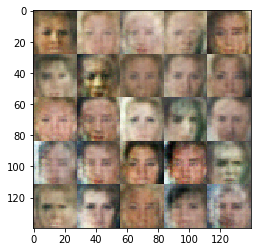

Epoch 0/1... discriminator Loss: 0.8542 Generator Loss 1.1171


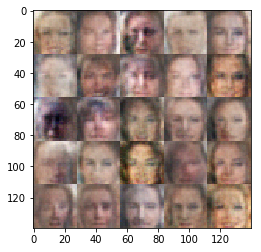

Epoch 0/1... discriminator Loss: 1.0299 Generator Loss 0.8280


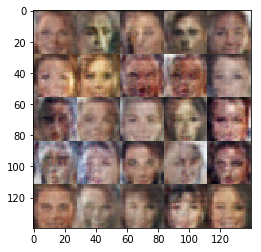

Epoch 0/1... discriminator Loss: 1.0082 Generator Loss 0.9170


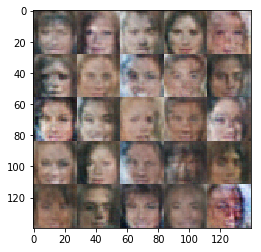

Epoch 0/1... discriminator Loss: 0.8139 Generator Loss 1.7472


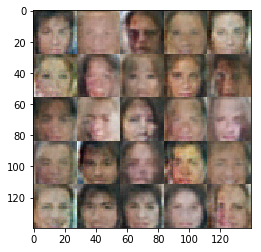

Epoch 0/1... discriminator Loss: 0.8096 Generator Loss 1.3331


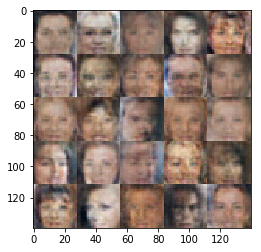

Epoch 0/1... discriminator Loss: 0.8559 Generator Loss 1.0420


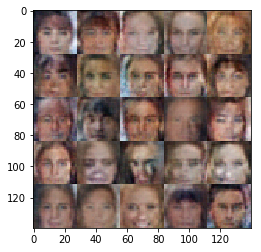

Epoch 0/1... discriminator Loss: 0.7851 Generator Loss 1.3847


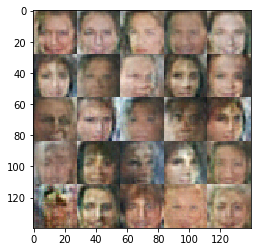

Epoch 0/1... discriminator Loss: 0.9504 Generator Loss 0.9156


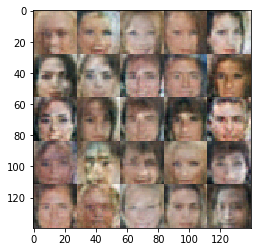

Epoch 0/1... discriminator Loss: 0.7554 Generator Loss 1.2776


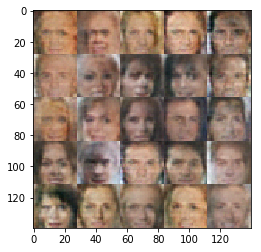

Epoch 0/1... discriminator Loss: 0.9156 Generator Loss 0.9366


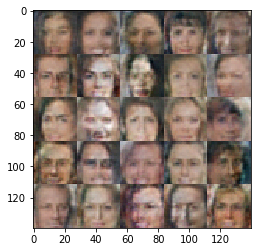

Epoch 0/1... discriminator Loss: 1.8937 Generator Loss 0.3382


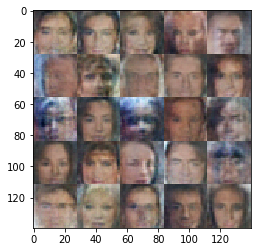

Epoch 0/1... discriminator Loss: 0.9921 Generator Loss 0.8296


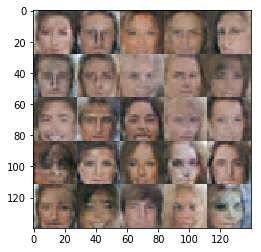

Epoch 0/1... discriminator Loss: 0.7361 Generator Loss 1.9334


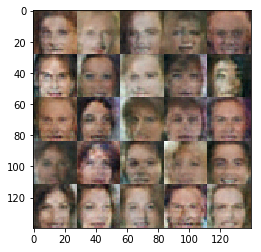

Epoch 0/1... discriminator Loss: 0.8920 Generator Loss 1.3777


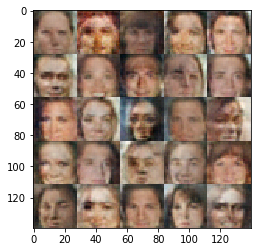

Epoch 0/1... discriminator Loss: 0.9851 Generator Loss 2.6415


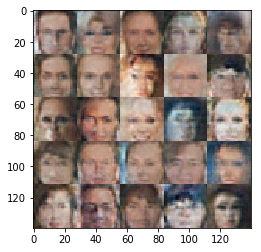

Epoch 0/1... discriminator Loss: 0.9321 Generator Loss 1.1449


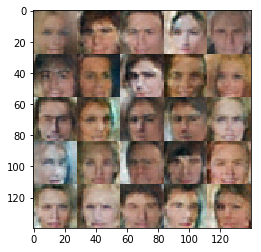

Epoch 0/1... discriminator Loss: 0.8035 Generator Loss 1.2410


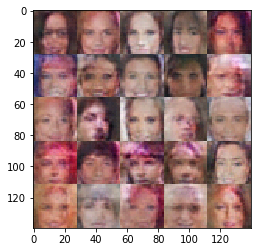

Epoch 0/1... discriminator Loss: 0.9172 Generator Loss 1.0934


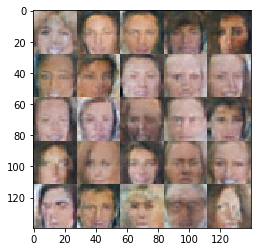

Epoch 0/1... discriminator Loss: 0.8233 Generator Loss 1.1690


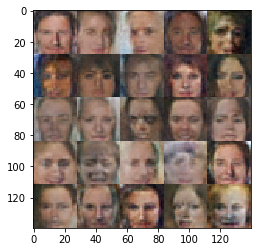

Epoch 0/1... discriminator Loss: 1.0559 Generator Loss 0.8280


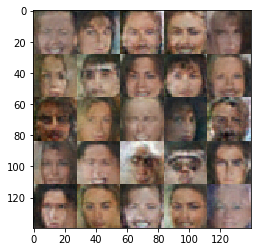

Epoch 0/1... discriminator Loss: 1.0082 Generator Loss 2.1490


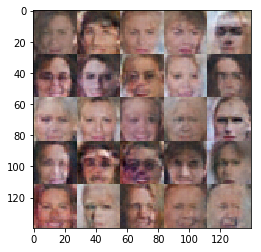

Epoch 0/1... discriminator Loss: 0.9006 Generator Loss 1.6068


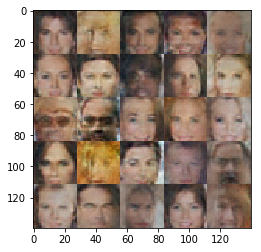

In [ ]:
batch_size = 64
z_dim = 50
learning_rate = 0.00025
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
# references:
# http://localhost:8888/notebooks/Desktop/Udacity/Nanodegrees/Deep_Learning/deep-learning/gan_mnist/Intro_to_GANs_Solution.ipynb
# http://localhost:8888/notebooks/Desktop/Udacity/Nanodegrees/Deep_Learning/deep-learning/gan_mnist/Intro_to_GANs_Exercises.ipynb
# https://www.sai-tai.com/demos/dl/face-generation.html
# https://github.com/bestkao/face_gen/blob/master/README.md
# https://mauriciocodesso.com/post/face-generator/
# https://github.com/atveit/FaceGenerationWithGAN/blob/master/dlnd_face_generation.py
    